In [1]:
!pip install diplib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 7.5 MB/s eta 0:00:00


In [2]:
#import necessary packages
import diplib as dip
import numpy as np
import matplotlib.pyplot as plt
from diplib import MeasurementTool as Tool
from diplib import Threshold, Label
from tifffile import tifffile as tiff
from PIL import Image, ImageFilter

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


In [3]:
# # mount to internal image files
# from google.colab import drive
# drive.mount('/content/drive/')
# path = '/content/drive/My Drive/ImageAnalysis/Practical6/'

In [5]:
path = "I:/My Drive/ImageAnalysis/Practical6/"

# Reading the Images

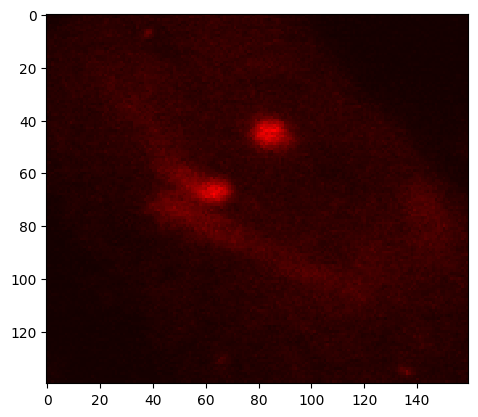

3D Scalar image:
    data type:      UINT8
    sizes:          {160, 140, 16}
    strides:        {1, 160, 22400}, tensor stride 1
    data pointer:   000002551C829400 (shared among 1 images)
    origin pointer: 000002551C829400



In [6]:
chromo_tif = dip.ImageReadTIFF(path + "CHROMO3D.tif")
chromo_tif.Show()

chromo_ics_data = dip.ImageReadICS(path +  "CHROMO3D.ICS")
#chromo_ic.Show()
print(chromo_ics_data)

In [7]:
tif_path = path + "CHROMO3D.tif"
tif = Image.open(tif_path)

# Size and Aspect Ratio

In [8]:
print(chromo_tif)
print("The aspect ratio is {}".format((160/140)))

2D Color image (3x1 column vector, 3 elements, sRGB):
    data type:      UINT16
    sizes:          {160, 140}
    strides:        {3, 480}, tensor stride 1
    data pointer:   00000255747152A0 (shared among 1 images)
    origin pointer: 00000255747152A0

The aspect ratio is 1.1428571428571428


# 3D Visualization of Plane

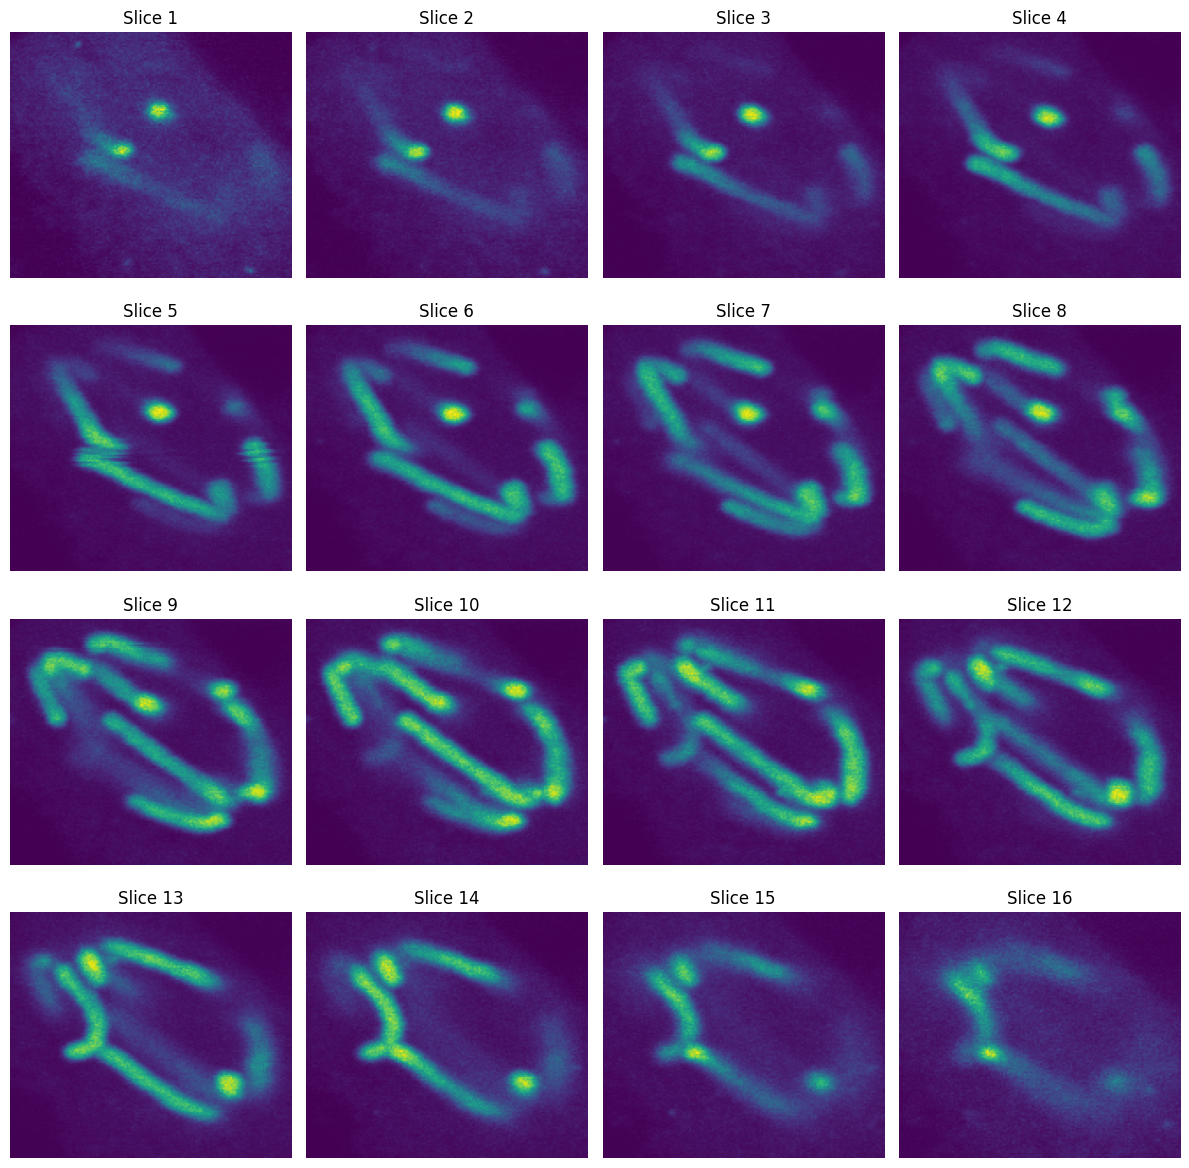

In [9]:
#for i ,j in zip(chromo_tif.get_iter_image(), fnames):i.get_frame().save(j,"TIFF")
num_slices = 16
fig, axes = plt.subplots(4,4, figsize =(12,12))
for i in range(num_slices):
  ax = axes[i // 4, i % 4]
  tif.seek(i)
  slice = np.array(tif)

  ax.imshow(slice)
  ax.axis('off')
  ax.set_title(f'Slice {i+1}')

plt.tight_layout()
plt.show()

# Thresholding

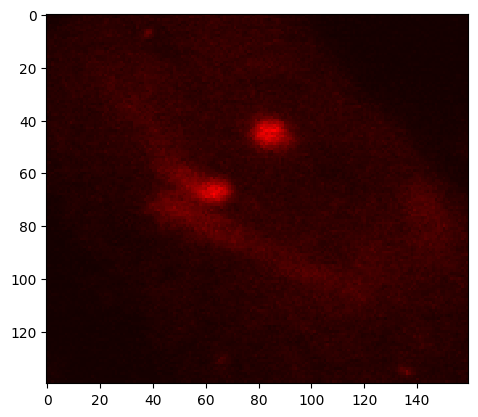

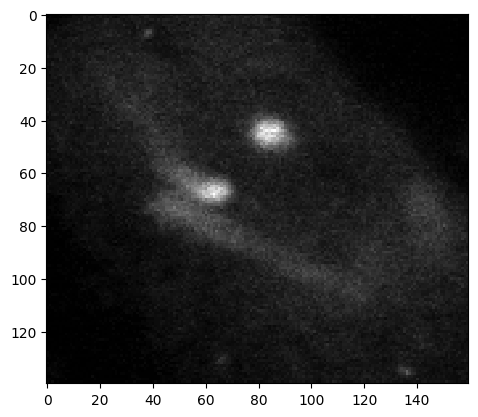

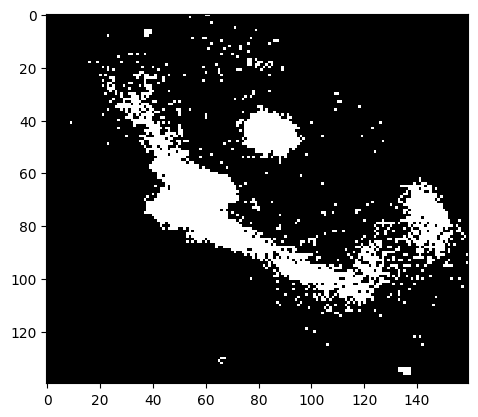

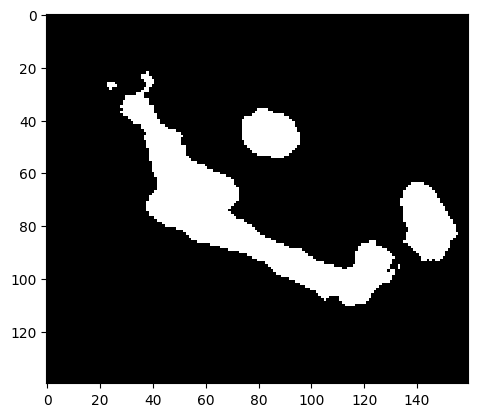

In [10]:
chromo_tif.Show()

image_array = np.array(chromo_tif)
gray_image = np.mean(image_array, axis=2)
gray_image_dip = dip.Image(gray_image)
gray_image_dip.Show()

mf_gdip = dip.MedianFilter(gray_image_dip)

otsu_thresh = dip.OtsuThreshold(gray_image_dip)
otsu_thresh.Show()

otsu_thresh_with_median = dip.OtsuThreshold(mf_gdip)
otsu_thresh_with_median.Show()

In [11]:
# Assuming chromo_tif is your 3D image stack
image_array = np.array(chromo_tif)
median_slices = []
# print(image_array.shape[2])
# Loop through each slice
for i in range(image_array.shape[2]):
    # Convert slice to grayscale
    gray_image = np.mean(image_array , axis=2)
    gray_image_dip = dip.Image(gray_image)
    mf_gdip = dip.MedianFilter(gray_image_dip)
    otsu_thresh = dip.OtsuThreshold(gray_image_dip)
    otsu_thresh_with_median = dip.OtsuThreshold(mf_gdip)

    # otsu_thresh_with_median = 1 - otsu_thresh_with_median
    #otsu_thresh_with_median.Show()
    median_slices.append(otsu_thresh_with_median)

median_slices_array = np.stack(median_slices, axis=0)
tiff.imwrite("Images/median_image.tiff",median_slices_array)
tiff.imwrite("Report/Images/median_otsu.png",median_slices_array)

# Maximum Intensity Projection

[255 238 221 204 187 170 153 136 119 102  85  68  51  34  17   0]


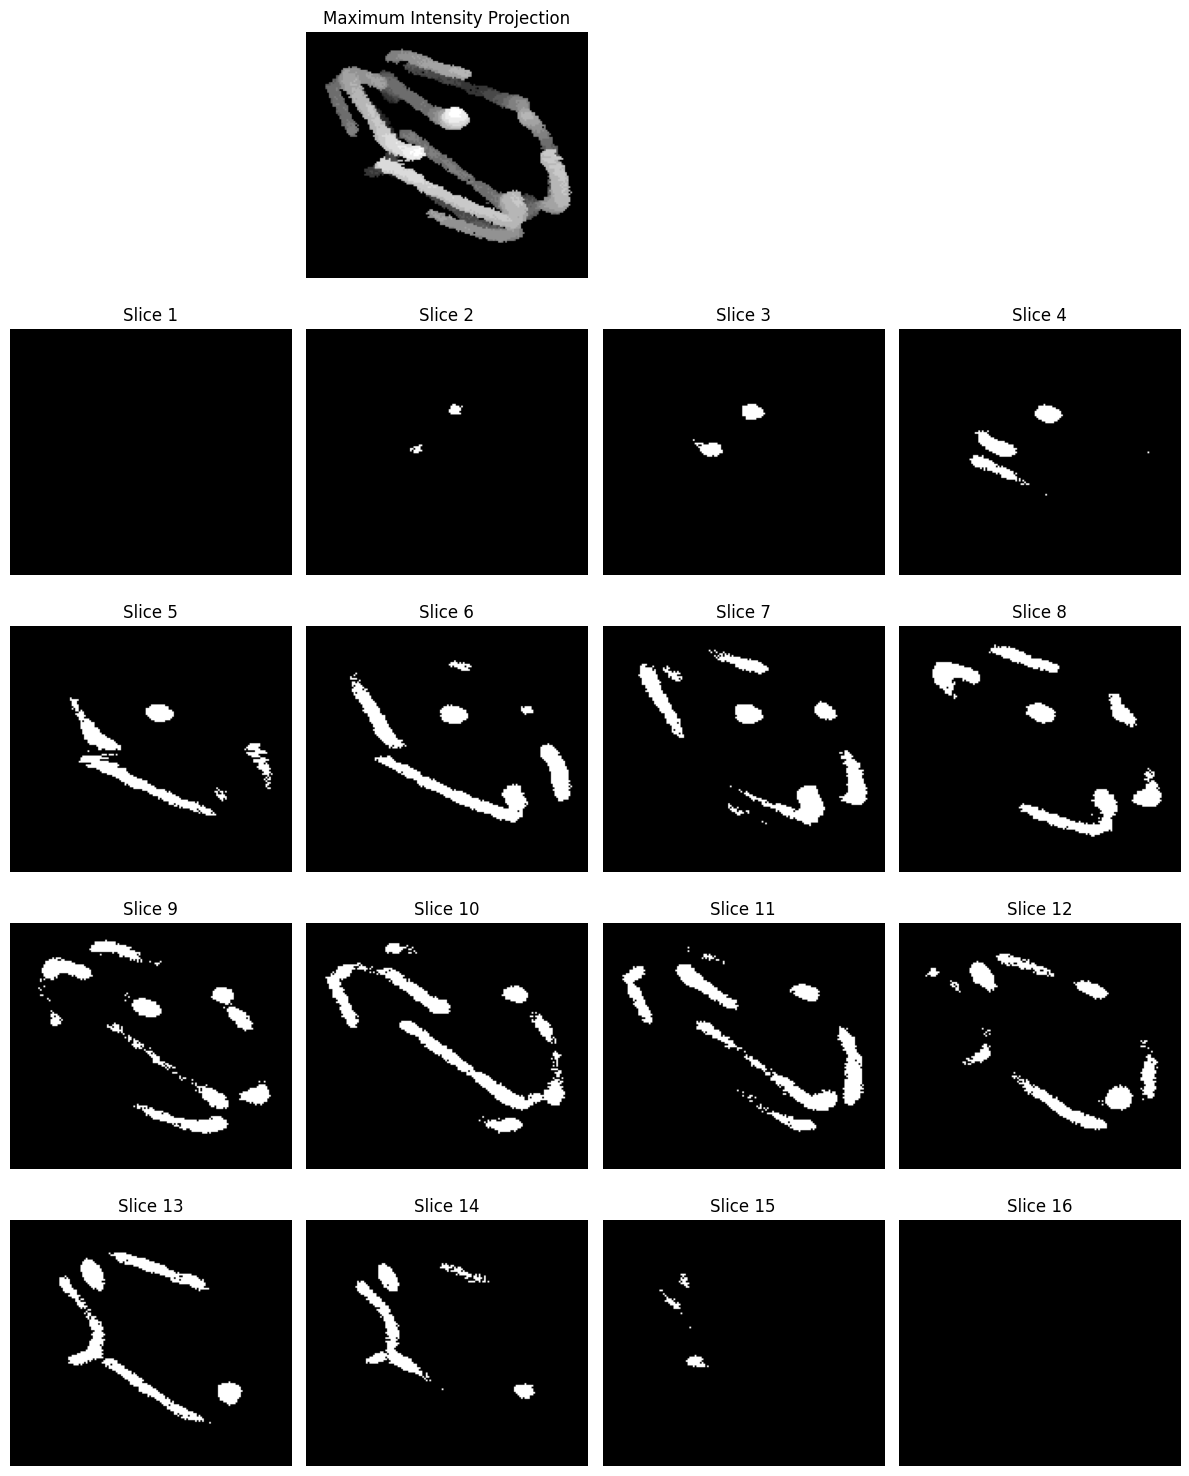

In [12]:
num_slices = 16
fig, axes = plt.subplots(5, 4, figsize=(12, 15))

fnames = ['1.tiff', '2.tiff', '3.tiff', '4.tiff',
          '5.tiff', '6.tiff', '7.tiff', '8.tiff',
          '9.tiff', '10.tiff', '11.tiff', '12.tiff',
          '13.tiff', '14.tiff', '15.tiff', '16.tiff']
threshold_value = 128

# Create an array to store all slices for MIP
all_slices = []

# Calculate intensity values for depth cuing
intensity_values = np.linspace(255, 0, num_slices, dtype=np.uint8)
print(intensity_values)

for i, fname in zip(range(num_slices), fnames):
    ax = axes[i // 4 + 1, i % 4]
    tif.seek(i)
    slice = np.array(tif)

    # Apply thresholding
    thresholded_slice = slice > threshold_value

    # Apply depth cueing by multiplying with the corresponding intensity value
    depth_cued_slice = thresholded_slice.astype(np.uint8) * intensity_values[i]

    # Store the slice for MIP calculation
    all_slices.append(depth_cued_slice)

    # Display the depth-cued slice
    ax.imshow(depth_cued_slice, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Slice {i + 1}')

    # Save the depth-cued slice as a TIFF file
    # Image.fromarray(depth_cued_slice).save(fname, "TIFF")

# Calculate the Maximum Intensity Projection (MIP)
all_slices_array = np.stack(all_slices, axis=0)
mip = np.max(all_slices_array, axis=0)

# Display the MIP
ax_mip = axes[0, 1]
ax_mip.imshow(mip, cmap='gray')
ax_mip.axis('off')
ax_mip.set_title('Maximum Intensity Projection')
# plt.show(ax_mip)

for j in range(num_slices, 16):
    ax = axes[j // 4 + 1, j % 4]
    ax.axis('off')

axes[0,0].remove()
axes[0,2].remove()
axes[0,3].remove()

plt.tight_layout()
plt.show()

plt.show(ax_mip)

In [14]:
# Saving the MIP Projection
all_slices_array = np.stack(all_slices, axis=0)
tiff.imwrite("Images/max_intensity.tiff",all_slices_array)

<Figure size 640x480 with 0 Axes>

In [19]:
# all_slices_array = np.stack(all_slices, axis=0)
# mip = np.max(all_slices_array, axis=0)

# plt.show(mip).all()
# plt.savefig("Report/Images/max_intensity.png")

# Converting the File to a TIFF File

In [39]:
f=LifFile(path + "team03.lif")

def Lif_to_Numpy ( image_stack ) :
  Channels = [ list () for _ in range ( image_stack.channels ) ]
  for C in range ( image_stack.channels ) :
    for frame in image.get_iter_z ( c = C ) :
      Channels [C].append (np.array ( frame ) )
  return np.array ( Channels )
#*******************************************************************************
def Save_Stacked_Image ( image , filename , path = '') :
  image = np.array ( dip.Image ( image ) )
  tiff.imwrite(path+filename+'.tiff', image)
#*******************************************************************************

for idx , image in enumerate ( f.get_iter_image () ) :
  img = Lif_to_Numpy ( image )
  # TODO DO YOUR SIGNAL ENHANCEMENT HERE
  Save_Stacked_Image ( img , "Images/" + f"Image_for_Huygens_{idx}")

def ReadStackedTiff ( filename , path) : # XXX Fill in your path
  image_stack = tiff.imread ( path + filename )
  print(f"The shape of { filename } is { image_stack.shape }")
  return image_stack
#*******************************************************************************
def Stack_to_dip_list ( imageStack ) :
  return [ dip.Image ( image ) for image in imageStack ]
#*******************************************************************************
# image_stack = ReadStackedTiff ( "Image_for_Huygens_0.tiff" )
# dipImages_stack = Stack_to_dip_list ( image_stack )